# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL # Python Image Library - Библиотека для работы с изображениями
print(PIL.__version__)

10.4.0


In [3]:
!nvidia-smi # - Вывод информации о работе карты NVIDIA. Полезна для мониторинга GPU 
import torch
torch.cuda.is_available() # True - если GPU доступен

Tue Dec 24 16:28:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [4]:
import pickle # Для сериализации и десериализации 
import numpy as np
from skimage import io # Для чтения и записи изображений

from tqdm import tqdm, tqdm_notebook # Для отображения прогресс - баров
from PIL import Image # Для работы с изображениями
from pathlib import Path # Для удобного управления файлами

from torchvision import transforms # Для преобразования изображений 
from multiprocessing.pool import ThreadPool # Для параллельного выполнения задач. Например - параллельно обработать 3 изображения.
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader # Классы для работы с данными в PyTorch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as tfs
from sklearn.metrics import f1_score


from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224 # Стандартное разрешение для работы многих архитектур (в т.ч. ResNet)
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

Добавим аугментацию картинок в метод getitem

In [6]:
class SimpsonsDataset(Dataset): # Наследуется от от базового класса Dataset, который предназачен для работы с данными. Основная задача - предоставить удобный интерфейс для загрузки, подготовки и передачи данных в модель
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__() # Конструктор родительского класса
        # список файлов для загрузки
        self.files = sorted(files) 
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError # Если такого режима (mode) нет - выкидывает ошибку NameError

        self.len_ = len(self.files) # Сохраняется длина набора данных

        self.label_encoder = LabelEncoder()

        if self.mode != 'test': # В тестовых данных в основном - неизвестны метки, мы хотим их предсказать 
            self.labels = [path.parent.name for path in self.files] # Создается список меток (Барт, Лиза) на основе имен директорий, содержащих изображения
            self.label_encoder.fit(self.labels) # Теперь эти метки переводятся из категориальных в числовую кодировку. 

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file) # Теперь кодировщик сохраняется с помощью pickle, чтобы его можно было использовать в будущем. Это нужно для того, чтобы при тестировании/валидации использовать тот же кодировщик, что и при обучении

    def __len__(self):
        return self.len_ # Возвращает длину данных

    def load_sample(self, file):
        image = Image.open(file) 
        image.load()
        return image # Загружает изображение и возвращает его. Для предварительной загрузки изображения перед дальнейшейобработкой

    def __getitem__(self, index):

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = Image.fromarray(x)
        
        if self.mode == 'train':
            augmentation = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            x = augmentation(x)
        else:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image) # Переводит изображение к нужному размеру и переводит в массив NumPy 

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset')

In [9]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [12]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

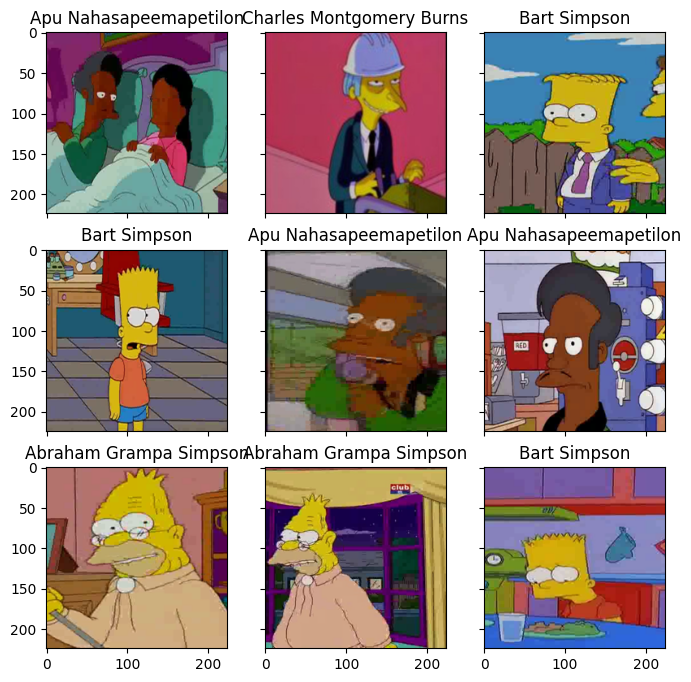

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5

Добавим Батч Нормализацию на первых двух свертках


In [14]:
# Очень простая сеть
class SimpleCnn(nn.Module): # Наследуется от nn.Module - это база

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes) # 96 - входные данные от прошлых нейронов, 5 на 5 - размер итогового изображения после всех пуллингов


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1) # Для подачи в линейный слой тензор плоской формы
        logits = self.out(x)
        return logits

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE) # Перевод данных на ГПУ
        labels = labels.to(DEVICE)
        optimizer.zero_grad() # Обнуляем градиенты

        outputs = model(inputs) # Выходные данные
        loss = criterion(outputs, labels) # рассчет лосса 
        loss.backward() # Обратный проход
        optimizer.step()  # Обновление весов модели на основе полученных градиентов 
        preds = torch.argmax(outputs, 1) # Вычисляет предсказанные классы, на основе максимума по первому каналу
        running_loss += loss.item() * inputs.size(0) 
        # loss.item() — это значение потери на текущем шаге. Оно отражает сумму квадратов разницы между реальными метками и предсказаниями модели.
        # Умножение на inputs.size(0) учитывает размер пакета данных. Это важно, потому что величина потери должна учитывать количество образцов в пакете. Ведь если пакет маленький, то ошибка будет меньше, чем если бы пакет был большой.
        running_corrects += torch.sum(preds == labels.data) # Кол-во правильных предсказаний 
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data # Среднее значение лосса на всей эпохе
    train_acc = running_corrects.cpu().numpy() / processed_data # Среднее значение Accuracy на эпохе
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval() # Перевод модели в режим прогнозирования. Она не будет изменять свои веса и делать обратный проход
    running_loss = 0.0 # Сумма лоссов на эпохах
    running_corrects = 0 # Кол-во правильных предсказаний 
    processed_size = 0 # Кол-во обработанных изображений

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE) # Перевод данных на ГПУ
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False): # Отключение обновления весов и обратного прохода. Нужно для прогнозирования
            outputs = model(inputs) # Делаем предсказания 
            loss = criterion(outputs, labels) # Считаем лосс
            preds = torch.argmax(outputs, 1) # Предсказание класса, который является наиболее вероятным 

        running_loss += loss.item() * inputs.size(0) # Умножение текущей ошибки на размер даты, чтобы учитывать размер даты
        running_corrects += torch.sum(preds == labels.data) # Подсчет правильных меток
        processed_size += inputs.size(0) # Добавление размера
    val_loss = running_loss / processed_size # Средний уровень потерь
    val_acc = running_corrects.double() / processed_size # Средняя точность модели. Метод .double() позволяет работать с дробными числами
    return val_loss, val_acc

Изменим функцию train, оптимизатор оставим прежним, установим маленький lr и добавим weight decay (регуляризация). Также добавляем lr sheduling (меняем шаг обучения пропорционально обучению)

Weight_decay борется с переобучением, обеспечивая устойчивость модели.

LR scheduling следит за тем, чтобы модель не училась слишком быстро или медленно, корректируя скорость обучения в зависимости от текущего состояния модели. (Не помогло)

Изменим batch_size на 128

Увеличим кол-во эпох 

In [27]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = [] # Сюда будут добавляться результаты после каждой эпохи
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}" # Просто шаблон для вывода

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(params=[
            {"params": model.fc.parameters()},
            {"params": model.layer1.parameters(), "lr": 1e-5,},
            {"params": model.layer2.parameters(), "lr": 1e-5,},
            {"params": model.layer3.parameters(), "lr": 1e-5,},
            {"params": model.layer4.parameters(), "lr": 1e-5,},
                ], 
            lr=1e-4
            )
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        # Тренировка по одной эпохе
        for epoch in range(epochs): # Цикл по эпохам
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            # Проверка на одной эпохе
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            # Обновление прогресса и вывод результатов
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [18]:
def predict(model, test_loader):
    with torch.no_grad(): # Отключаем подсчет градиентов и обратных проход
        logits = [] # Выходые данные (логиты)

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy() # Преобразование в вероятности. torch.cat - объединяет все логиты,softmax переводит в вероятности, результат идет в numpy массив 
    return probs

In [19]:
n_classes = len(np.unique(train_val_labels)) # сколько уникальных меток - столько и уникальных классов
simple_cnn = SimpleCnn(n_classes).to(DEVICE) # Передаем модели кол-во классов 
print("we will classify :{}".format(n_classes)) # сколько классов будет классифицроваться
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, ker

Запустим обучение сети.

In [20]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [96]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.3739847190532422


epoch:  10%|█         | 1/10 [02:26<22:01, 146.86s/it]


Epoch 001 train_loss: 1.3740     val_loss 1.4275 train_acc 0.6179 val_acc 0.6011
loss 1.2302467161260962


epoch:  20%|██        | 2/10 [04:54<19:36, 147.07s/it]


Epoch 002 train_loss: 1.2302     val_loss 1.5551 train_acc 0.6530 val_acc 0.5883
loss 1.1623976857686955


epoch:  30%|███       | 3/10 [07:23<17:16, 148.01s/it]


Epoch 003 train_loss: 1.1624     val_loss 1.3204 train_acc 0.6715 val_acc 0.6358
loss 1.09133492612453


epoch:  40%|████      | 4/10 [09:49<14:44, 147.44s/it]


Epoch 004 train_loss: 1.0913     val_loss 1.3417 train_acc 0.6904 val_acc 0.6374
loss 1.0273756972922892


epoch:  50%|█████     | 5/10 [12:16<12:16, 147.22s/it]


Epoch 005 train_loss: 1.0274     val_loss 1.2996 train_acc 0.7062 val_acc 0.6399
loss 0.9976665142638128


epoch:  60%|██████    | 6/10 [14:41<09:46, 146.59s/it]


Epoch 006 train_loss: 0.9977     val_loss 1.3047 train_acc 0.7119 val_acc 0.6368
loss 0.9646597409394146


epoch:  70%|███████   | 7/10 [17:01<07:12, 144.33s/it]


Epoch 007 train_loss: 0.9647     val_loss 1.2097 train_acc 0.7238 val_acc 0.6767
loss 0.9198072661532818


epoch:  80%|████████  | 8/10 [19:19<04:44, 142.28s/it]


Epoch 008 train_loss: 0.9198     val_loss 1.2203 train_acc 0.7315 val_acc 0.6706
loss 0.8955171524403892


epoch:  90%|█████████ | 9/10 [21:38<02:21, 141.18s/it]


Epoch 009 train_loss: 0.8955     val_loss 1.1996 train_acc 0.7417 val_acc 0.6846
loss 0.8676145253906479


epoch: 100%|██████████| 10/10 [23:56<00:00, 143.64s/it]


Epoch 010 train_loss: 0.8676     val_loss 1.1720 train_acc 0.7518 val_acc 0.6836


Построим кривые обучения

2.46 - изначальное качество

1.76 - после обновления функции train

1.52 - после удаления lr scheduler

1.02 - после добавления аугментации

0.87 - 10 эпох

In [97]:
loss, acc, val_loss, val_acc = zip(*history)

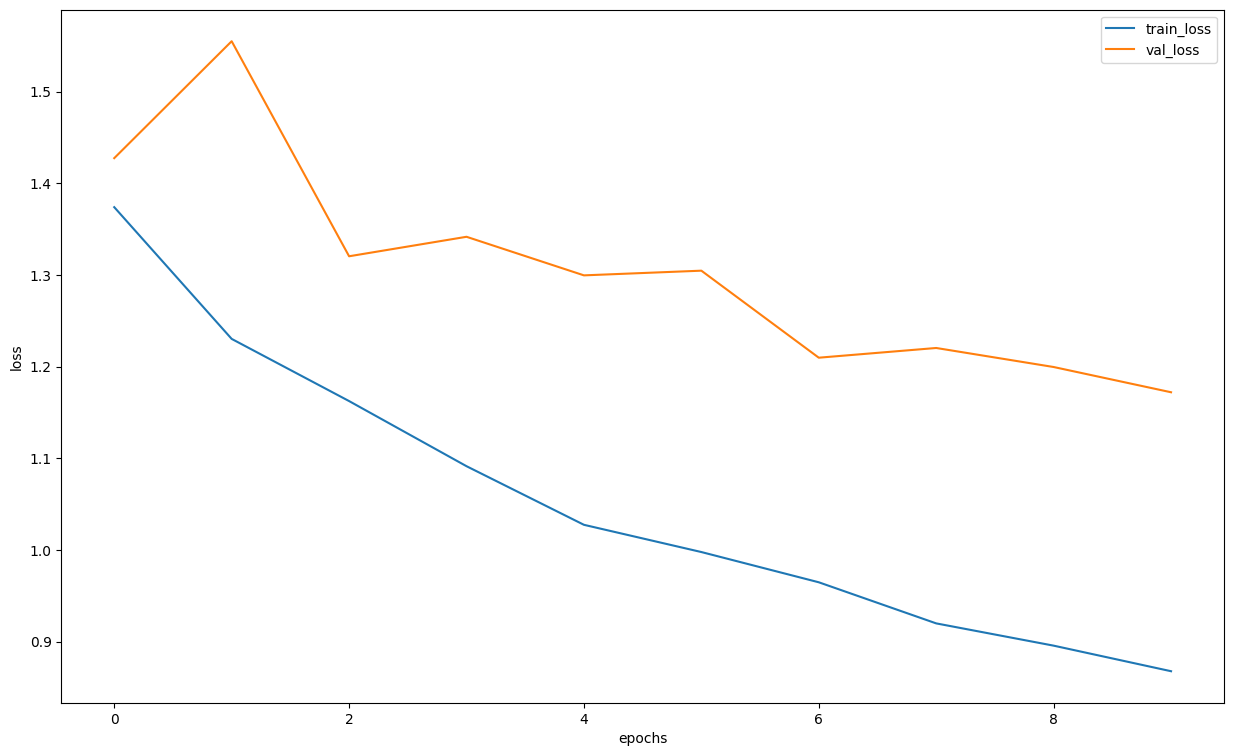

In [98]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [33]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [34]:
random_characters = int(np.random.uniform(0,1000)) # Создаем случайное число 
ex_img, true_label = val_dataset[random_characters] # Выбираем 
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0)) # добавляет дополнительное измерение к тензору изображения

In [35]:
idxs = list(map(int, np.random.uniform(0,1000, 20))) # 20 Случайных чисел от 0 до 1000
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs] # Извлечение изображения по индексу

probs_ims = predict(simple_cnn, imgs) # делаем предсказания

In [36]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [37]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

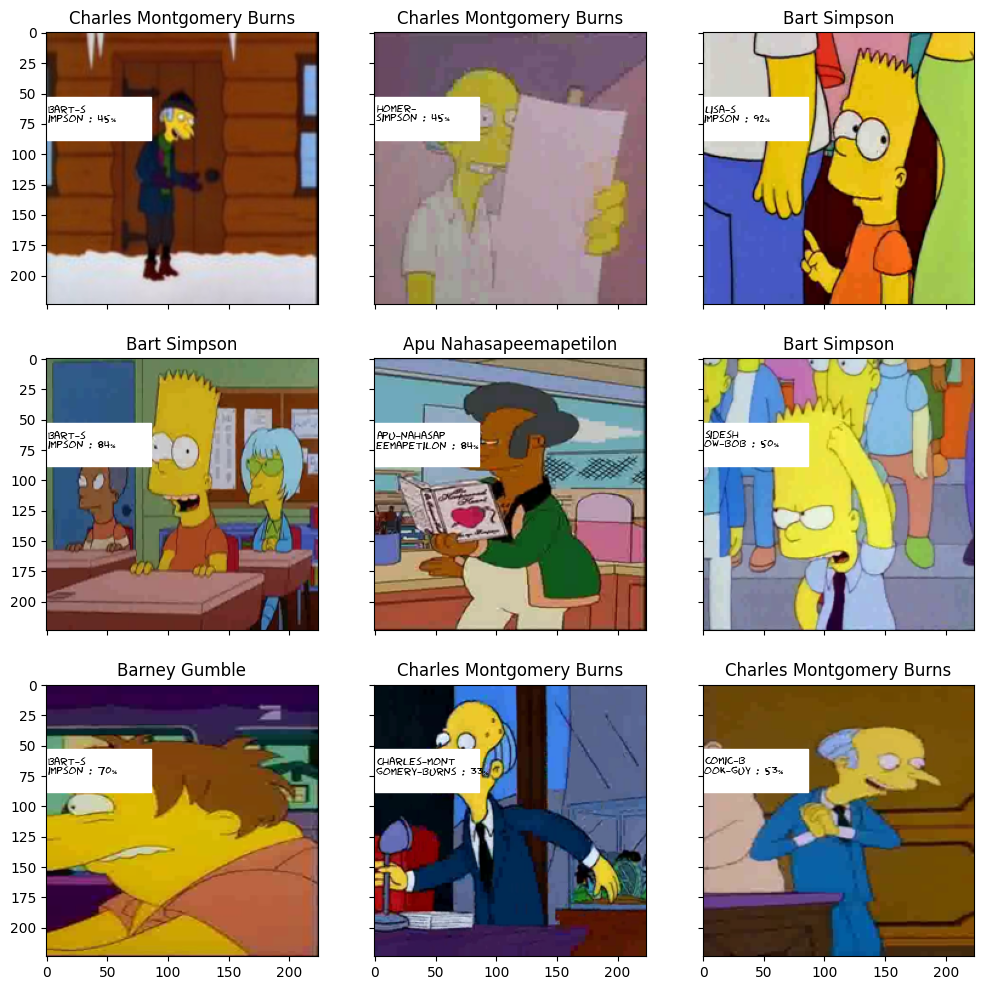

In [105]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


Попробуем решить задачу с помощью ResNet18 на 15 эпохах с размером батча - 64

In [21]:
import torchvision.models as models

# Импортируем модель ResNet18
model_resnet18 = models.resnet18(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s] 


In [22]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
in_features=512
out_features = n_classes

model_resnet18.to(DEVICE)
model_resnet18.fc = nn.Linear(in_features, out_features)

In [24]:
if model_resnet18.to(DEVICE):
    print("Модель находится на CUDA.")
else:
    print("Модель не на CUDA.")

Модель находится на CUDA.


In [28]:
res_his = train(train_dataset, val_dataset, model=model_resnet18, epochs=15, batch_size=64)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.17452808639247128


epoch:   7%|▋         | 1/15 [03:53<54:34, 233.86s/it]


Epoch 001 train_loss: 0.1745     val_loss 0.1779 train_acc 0.9627 val_acc 0.9599
loss 0.17001848013590942


epoch:  13%|█▎        | 2/15 [07:18<46:54, 216.51s/it]


Epoch 002 train_loss: 0.1700     val_loss 0.1553 train_acc 0.9531 val_acc 0.9652
loss 0.07387655375991521


epoch:  20%|██        | 3/15 [10:35<41:33, 207.80s/it]


Epoch 003 train_loss: 0.0739     val_loss 0.1866 train_acc 0.9807 val_acc 0.9578
loss 0.05669802884179184


epoch:  27%|██▋       | 4/15 [13:52<37:18, 203.51s/it]


Epoch 004 train_loss: 0.0567     val_loss 0.1789 train_acc 0.9846 val_acc 0.9589
loss 0.04704417852210622


epoch:  33%|███▎      | 5/15 [17:14<33:48, 202.89s/it]


Epoch 005 train_loss: 0.0470     val_loss 0.1463 train_acc 0.9869 val_acc 0.9685
loss 0.04356496441500448


epoch:  40%|████      | 6/15 [20:44<30:47, 205.33s/it]


Epoch 006 train_loss: 0.0436     val_loss 0.1533 train_acc 0.9876 val_acc 0.9624
loss 0.026628486555361795


epoch:  47%|████▋     | 7/15 [24:05<27:10, 203.83s/it]


Epoch 007 train_loss: 0.0266     val_loss 0.1491 train_acc 0.9932 val_acc 0.9696
loss 0.03644922337012578


epoch:  53%|█████▎    | 8/15 [27:23<23:34, 202.01s/it]


Epoch 008 train_loss: 0.0364     val_loss 0.2358 train_acc 0.9897 val_acc 0.9522
loss 0.01867023443597516


epoch:  60%|██████    | 9/15 [30:42<20:06, 201.10s/it]


Epoch 009 train_loss: 0.0187     val_loss 0.2150 train_acc 0.9946 val_acc 0.9580
loss 0.03157434070252556


epoch:  67%|██████▋   | 10/15 [34:03<16:46, 201.21s/it]


Epoch 010 train_loss: 0.0316     val_loss 0.2125 train_acc 0.9906 val_acc 0.9597
loss 0.0310844066135142


epoch:  73%|███████▎  | 11/15 [37:22<13:22, 200.50s/it]


Epoch 011 train_loss: 0.0311     val_loss 0.1533 train_acc 0.9903 val_acc 0.9660
loss 0.013490705344593226


epoch:  80%|████████  | 12/15 [40:44<10:02, 200.93s/it]


Epoch 012 train_loss: 0.0135     val_loss 0.1819 train_acc 0.9962 val_acc 0.9637
loss 0.02285912932560517


epoch:  87%|████████▋ | 13/15 [44:06<06:42, 201.14s/it]


Epoch 013 train_loss: 0.0229     val_loss 0.1613 train_acc 0.9941 val_acc 0.9696
loss 0.017364782524369217


epoch:  93%|█████████▎| 14/15 [47:28<03:21, 201.35s/it]


Epoch 014 train_loss: 0.0174     val_loss 0.1691 train_acc 0.9950 val_acc 0.9627
loss 0.02042397835183775


epoch: 100%|██████████| 15/15 [50:49<00:00, 203.28s/it]


Epoch 015 train_loss: 0.0204     val_loss 0.1644 train_acc 0.9942 val_acc 0.9639


###### 

In [38]:
loss, acc, val_loss, val_acc = zip(*res_his)

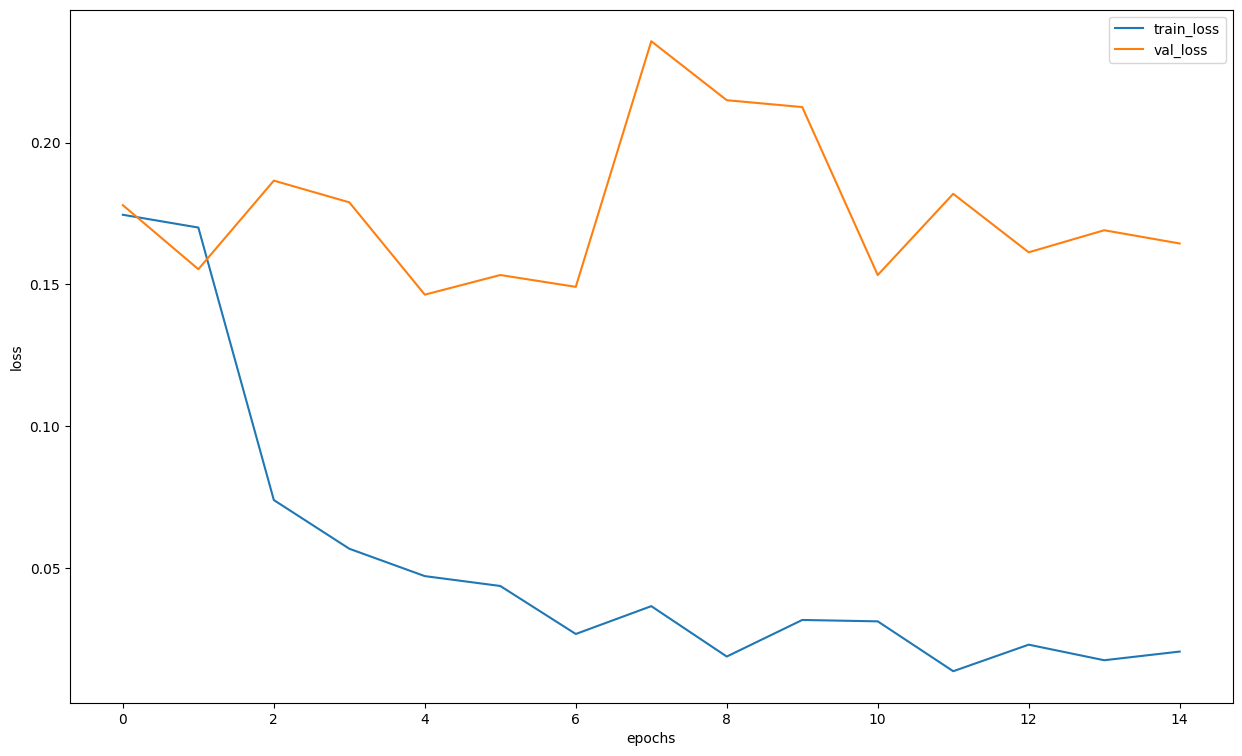

In [39]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [40]:
random_characters = int(np.random.uniform(0,1000)) # Создаем случайное число 
ex_img, true_label = val_dataset[random_characters] # Выбираем 
probs_im = predict_one_sample(model_resnet18, ex_img.unsqueeze(0)) # добавляет дополнительное измерение к тензору изображения
idxs = list(map(int, np.random.uniform(0,1000, 20))) # 20 Случайных чисел от 0 до 1000
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs] # Извлечение изображения по индексу

probs_ims = predict(model_resnet18, imgs) # делаем предсказания

In [41]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [44]:
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 1.0


In [48]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet18, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [49]:
import pandas as pd
my_submit2 = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit2.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [50]:
my_submit2.to_csv('subm_resnet_15_epoch.csv', index=False)